# Comentario de Telegram

Para el que le interese y siguiendo el libro de Marcos Lopez... como crear Tick bars, volume, dv, imbalance and run bars...

In [83]:
!pip install tqdm

In [0]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats


**read_ticks** optimized to read IEX ticks, but it can be modified to read ticks from any source
The requirement is a dataframe with columns "price" and "size"

In [0]:
def read_ticks(i):
  
  df = pd.read_pickle("SPY_IEX_ticktrades_"+i+".pkl", compression='gzip')
  df.reset_index(level=0, inplace=True)
  df = pd.DataFrame([{'Timestamp': k,
                   'price': v.price.mean(),
                   'size': round(v['size'].sum())}
                    for k,v in df.groupby(['Timestamp'])],
                    columns=['Timestamp', 'price', 'size'])
    
  df = df.set_index('Timestamp')

  return df

In [0]:
def mad_outlier(y, thresh=3):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [0]:
def removeOutliers(df):
    
    mad = mad_outlier(df.price.values.reshape(-1,1))
    df = df.loc[~mad]
    
    return df

In [0]:
def tick_bars(df, price_column, m):
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(t):
        if price_column == 'price':
          ts += 1
        else:
          ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

In [0]:
def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()
    #return df.iloc[idx]

In [0]:
def tickBars(dateFrom,          # Initial date on the range
             dateTo,            # Final date on the range
             tick_M,            # Thresold : Number of ticks per bar
             tdhFrom,           # 13:29:59
             tdhTo,             # 19:59:59
             interpolate,       # linear
             column):

    dfTS = pd.DataFrame()
    
    for i in tqdm(range(int(dateFrom), int(dateTo))):
        # Read the ticks for a date from the file
        try:
            df=read_ticks(str(i))
            df=df.assign(v=lambda df: df['size'])
            df=df.assign(dv=lambda df: df['price']*df['size'])
        
            # Adjust ticks to Trading hours
            if tdhFrom != "":
                df = df.loc[str(i)+" "+tdhFrom:]
            if tdhTo != "":
                df = df.loc[:str(i)+" "+tdhTo]
                
            #RemoveOutliers
            df = removeOutliers(df)
            #sns.boxplot(df.price)
    
            df = tick_bar_df(df, column, tick_M)
        
            # Interpolate on timeframes
            if interpolate != "":
                df=df.interpolate(method=interpolate)
        
            dfTS = dfTS.append(df)
        except:
            print("Day %s doesn´t exist" % str(i))
        
    return dfTS

In [0]:
def timeBars(dateFrom,          # Initial date on the range
             dateTo,            # Final date on the range
             timeframe,         # 1S, 1Min, 1H, 1D, 1W, 1M, 1Q, 1A
             tdhFrom,           # 13:29:59
             tdhTo,             # 19:59:59
             interpolate):      # linear

    dfTS = pd.DataFrame()
    
    for i in tqdm(range(int(dateFrom), int(dateTo))):
        # Read the ticks for a date from the file
        try:
            df=read_ticks(str(i))
        
            # Adjust ticks to Trading hours
            if tdhFrom != "":
                df = df.loc[str(i)+" "+tdhFrom:]
            if tdhTo != "":
                df = df.loc[:str(i)+" "+tdhTo]
                
            #RemoveOutliers
            df = removeOutliers(df)
            #sns.boxplot(df.price)
    
            # Types of resampling
            # http://benalexkeen.com/resampling-time-series-data-with-pandas/
            df1=df['price'].resample(timeframe).ohlc()
            df1['volume']=df.resample(timeframe,closed='left', label='left').sum()['size']
        
            # Interpolate on timeframes
            if interpolate != "":
                df1=df1.interpolate(method=interpolate)
        
            dfTS = dfTS.append(df1)
        except:
            print("Day %s doesn´t exist" % str(i))
        
    return dfTS

In [0]:
def imbalance_tick(t):
    n = t.size
    imbalance = pd.Series(np.nan for _ in range(0,n))
    price_diff = t[1:] - t[:-1]
    imbalance[0] = np.sign(price_diff[0])
    for i in range(1,n-1):
        imbalance[i] = np.sign(price_diff[i])*(price_diff[i]!=0) + imbalance[i-1]*(price_diff[i]==0)
    
    return imbalance.dropna()

In [0]:
def agg_imbalance_bars(df, Tvec):
    """
    Implements the accumulation logic
    """
    start = df.index[0] 
    j = 0
    bars = []
    for i in Tvec:
        stop = df.index[int(j+i)]
        bars.append((start,stop))
        j += i
        start = stop
        
    return bars

In [0]:
def get_imbalance_bars(df, column, w0=10, bkw_T=5, bkw_b=5):    
    nx = len(df)
    b_t = imbalance_tick(df[column].values).values
    
    w0 = max(min([x for x in np.cumsum(b_t) if x != 0]), w0) # fix the case when there are always 0 at the beginning
    Tvec = np.r_[w0]
    E0T = Tvec
    
    while 1==1:
        T_last = sum(Tvec) # the last T that has been calculated
        
        nbt = min(bkw_b, T_last - 1)
        PminusP = pd.Series(b_t[int(T_last-nbt):int(T_last)]).ewm(nbt).mean()       
        PminusP = PminusP[len(PminusP)-1] # the last one is what we need
        b_t_Expected = E0T*abs(PminusP)
        b_t_psum = abs(np.cumsum(b_t[1:-int(T_last)]))
        
        if len(b_t_psum) == 0 or (max(b_t_psum) < b_t_Expected):
            break
        else:
            T_new = min([x for x in b_t_psum[b_t_psum >=b_t_Expected] if x != 0])

        T_last = T_last + T_new    
        
        if T_last > nx:
            break
        else:
            Tvec = np.r_[Tvec, T_new]
            nTvec = len(Tvec)
            
            if nTvec <= 2 :
                E0T = Tvec.mean()
            else:
                nT = min(bkw_T, len(Tvec)-1)
                E0T = pd.Series(Tvec[(nTvec-nT):nTvec]).ewm(nT).mean()
                E0T = E0T[len(E0T)-1]
                
    bars = agg_imbalance_bars(df, Tvec)
    run_bars = (pd.DataFrame(bars,columns=['start','stop'])
                     .drop_duplicates())
    
    return run_bars

In [0]:
def get_run_bars(df, column, w0=10, bkw_T=5, bkw_Pb1=5):
    b_t = imbalance_tick(df[column].values).values

    nb = b_t.size
    nx = len(df)
    
    th_T = []
    # calculate the length of the 1st run
    for i in range(1,nb):
        b_t_tmp = b_t[1:i]
        out = max(b_t_tmp[b_t_tmp==1].size, b_t_tmp[b_t_tmp==-1].size)  
        th_T.append(out)
    
    w0 = max(min([x for x in th_T if x != 0]), w0) # fix the case when there are always 0 at the beginning
    w0 = max(min([x for x in b_t if x == 1]), w0) # there must be at least 1 b_t = 1 during the first window

    Tvec = np.r_[w0]
    E0T = T_last = Tvec
    Pb1 = sum(b_t[1:w0]==1) / w0 # Pb1: Pr[b_t = 1]
    Pb1vec = Pb1
    th_T_Expected = E0T*max(Pb1, 1-Pb1)

    while T_last<nx :
        T_last = sum(Tvec)  # the last T that has been calculated
        # cat("T_last: ", T_last, "\n")
        for j in range(1,(nb-T_last-1)):
            b_t_tmp = b_t[(T_last+1):(T_last+j)]
            th_T_tmp = max(b_t_tmp[b_t_tmp==1].size, -b_t_tmp[b_t_tmp==-1].size)
            if th_T_tmp >= th_T_Expected:
                new_flag = True
                T_new = j
                Tvec = np.r_[Tvec, T_new]
                T_last = T_last + T_new
                
                Pb1_new = sum(b_t_tmp[b_t_tmp==1]) / j
                Pb1vec = np.r_[Pb1vec, Pb1_new]
                break
            
        if new_flag == True:
            new_flag = False
            nTvec = len(Tvec) # nTvec should be the same as nPb1vec
            if nTvec <= 2:
                E0T = Tvec.mean() # not enough T for exponential weighted average, so use the mean
                Pb1 = Pb1vec.mean()
            else:
                nT = min(bkw_T, len(Tvec)-1) 
                E0T =  pd.Series(Tvec[(nTvec-nT):nTvec]).ewm(nT).mean()                
                E0T = E0T[len(E0T)-1]
                nPb1 = min(bkw_Pb1, len(Tvec)-1)
                Pb1 = pd.Series(Pb1vec[(nTvec-nPb1):nTvec]).ewm(nPb1).mean()                
                Pb1 = Pb1[len(Pb1)-1]
            
            th_T_Expected = E0T*max(Pb1, 1-Pb1)
        else:
            break
        
    bars = agg_imbalance_bars(df, Tvec)
    run_bars = (pd.DataFrame(bars,columns=['start','stop'])
                     .drop_duplicates())
    
    return run_bars

In [0]:
def analysisImbalanceBars(bar_types, bar_returns):
    get_test_stats(bar_types,bar_rets,pd.Series.autocorr)
    
    plot_autocorr(bar_types,bar_returns)
    
    plot_hist(bar_types,bar_returns)
    
    jbs = get_test_stats(bar_types,bar_returns,jb).sort_values('jb_stat')
    shaps = (get_test_stats(bar_types,bar_returns,shapiro)
             .sort_values('shapiro_stat')[::-1])
    
    display(jbs,shaps)

In [0]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

In [0]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds)) 
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [0]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, ax=axes[i],
                                 alpha=0.05, unbiased=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()   

In [0]:
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_rets, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()    

In [0]:
def jb(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.jarque_bera(x)[0]
    return stats.jarque_bera(x)[1]


In [0]:
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

In [0]:
def select_sample_data(ref, sub, price_col, date):
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

In [0]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

In [0]:
def get_ohlc(ref, sub):
    ohlc = []
    for i in tqdm(range(sub.index.shape[0]-1)):
        start,end = sub.index[i], sub.index[i+1]
        tmp_ref = ref.loc[start:end]
        max_px, min_px = tmp_ref.max(), tmp_ref.min()
        o,h,l,c = sub.iloc[i], max_px, min_px, sub.iloc[i+1]
        ohlc.append((end,start,o,h,l,c))
    cols = ['end','start','open','high','low','close']
    tick_bars_ohlc = (pd.DataFrame(ohlc,columns=cols))
    tick_bars_ohlc = tick_bars_ohlc.set_index(pd.to_datetime(tick_bars_ohlc.start))
    tick_bars_ohlc = tick_bars_ohlc.drop(['start','end'], axis=1)
    
    return tick_bars_ohlc 

In [0]:
def plotOHLC(df):
    opens = pd.Series(df.open)
    highs = pd.Series(df.high)
    lows = pd.Series(df.low)
    closes = pd.Series(df.close)
    
    import matplotlib.pyplot as plt
    import matplotlib.finance as mpf
    
    fig, ax = plt.subplots(figsize=(8,5))
    mpf.candlestick2_ochl(ax, opens, closes, highs, lows, width=0.5, colorup='k', colordown='r', alpha=0.75)
    plt.show()

**TIME BARS**

  0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


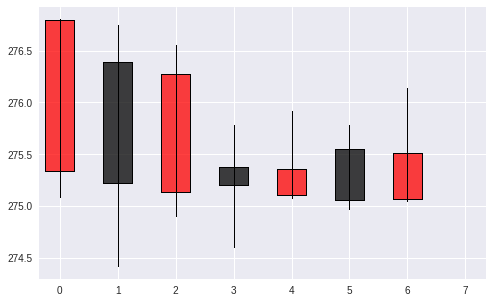

In [107]:
df = timeBars("20181022", "20181023", "1Min", "13:29:59", "19:59:59", "linear")
df = timeBars("20181022", "20181023", "1H", "13:29:59", "19:59:59", "linear")

plotOHLC(df)

**TICK BARS**

  0%|          | 0/1 [00:00<?, ?it/s]

tick threshold: 100
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 48/48 [00:00<00:00, 2108.29it/s]


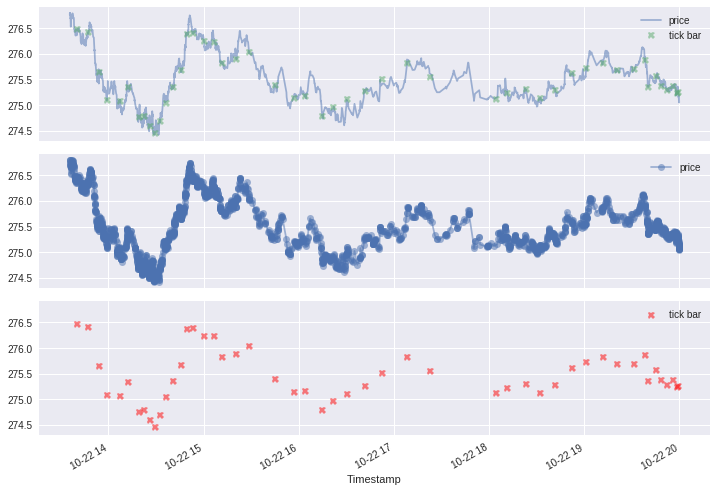

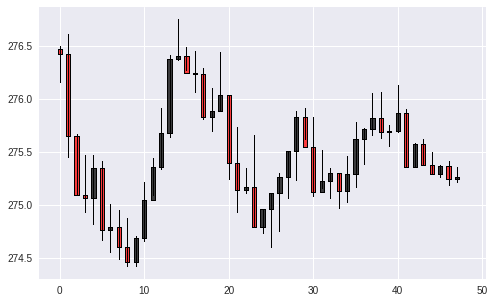

In [108]:
tick_M = 100 # arbitrary number of ticks on each bar

print(f'tick threshold: {tick_M:,}')

df1 = tickBars("20181022", "20181023", 1, "13:29:59", "19:59:59", "linear", "price")
tick_df = tickBars("20181022", "20181023", tick_M, "13:29:59", "19:59:59", "linear", "price")

xdf, xtdf = select_sample_data(df1, tick_df, 'price', '20181022')
plot_sample_data(xdf, xtdf, 'tick bar', alpha=0.5, markersize=7)

tick_bars_ohlc = get_ohlc(df1.price, tick_df.price)    
plotOHLC(tick_bars_ohlc)


**VOLUME BARS**

  0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 642/642 [00:00<00:00, 2827.48it/s]


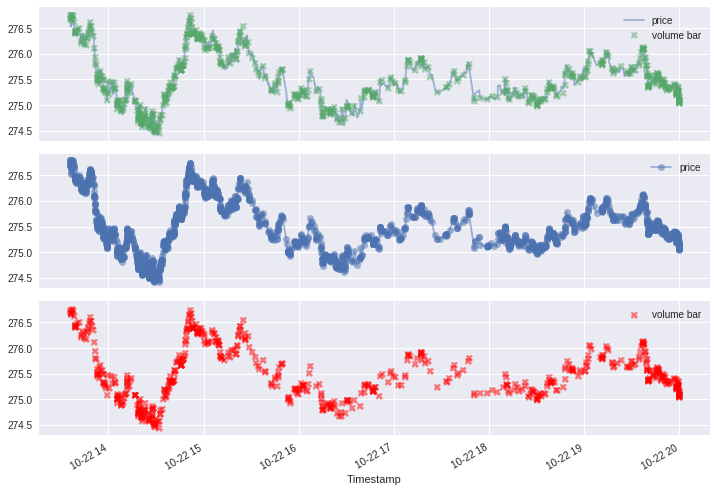

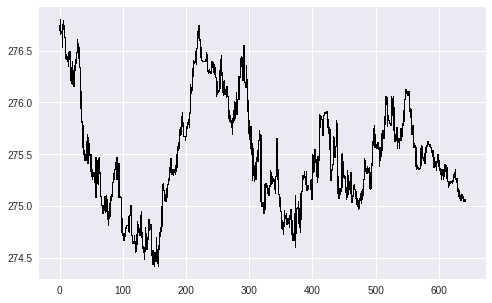

In [109]:
volume_M =  1000 # arbitrary number of volume on each bar
    
#print(f'volume threshold: {volume_M:,}')

v_bar_df = tickBars("20181022", "20181023", volume_M, "13:29:59", "19:59:59", "linear", "v")

xdf, xtdf = select_sample_data(df1, v_bar_df, 'price', '20181022')
plot_sample_data(xdf, xtdf, 'volume bar', alpha=0.5, markersize=7)

volume_bars_ohlc = get_ohlc(df1.price, v_bar_df.price)    
plotOHLC(volume_bars_ohlc)

**DOLLAR VOLUME BARS**

  0%|          | 0/1 [00:00<?, ?it/s]

dollar threshold: 1,000,000
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 239/239 [00:00<00:00, 2495.62it/s]


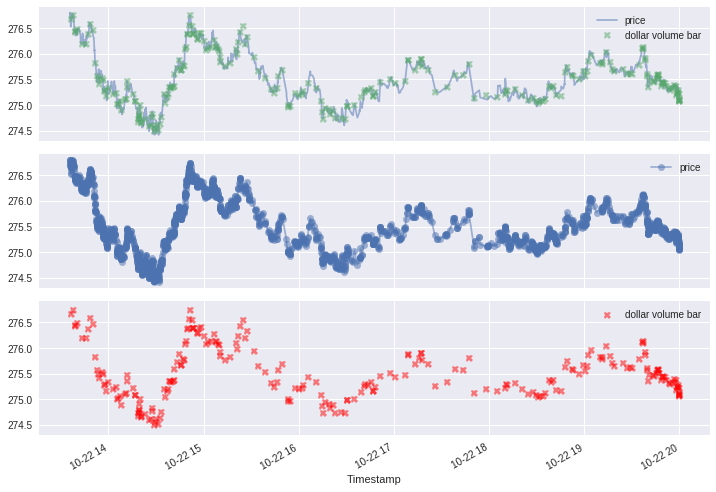

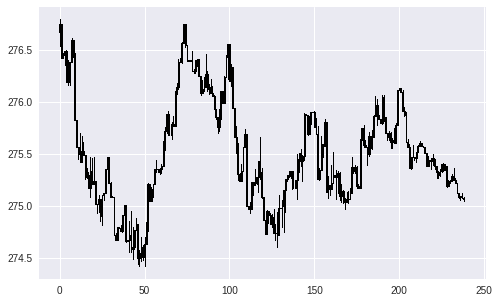

In [110]:
dollar_M = 1_000_000 # arbitrary 
    
print(f'dollar threshold: {dollar_M:,}')

dv_bar_df = tickBars("20181022", "20181023", dollar_M, "13:29:59", "19:59:59", "linear", "dv")

xdf, xtdf = select_sample_data(df1, dv_bar_df, 'price', '20181022')
plot_sample_data(xdf, xtdf, 'dollar volume bar', alpha=0.5, markersize=7)

dollar_bars_ohlc = get_ohlc(df1.price, dv_bar_df.price)    
plotOHLC(dollar_bars_ohlc)


**TICKS IMBALANCE BARS**

,sample_size,jb_stat
ticksBar,48.0,1.742906
ticksImbBars,486.0,1279.718714


,sample_size,shapiro_stat
ticksBar,48.0,0.965380
ticksImbBars,486.0,0.882581


100%|██████████| 486/486 [00:00<00:00, 3333.93it/s]


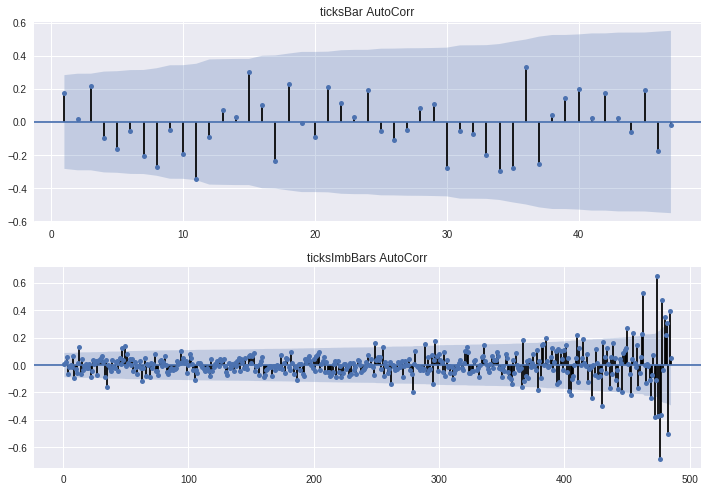

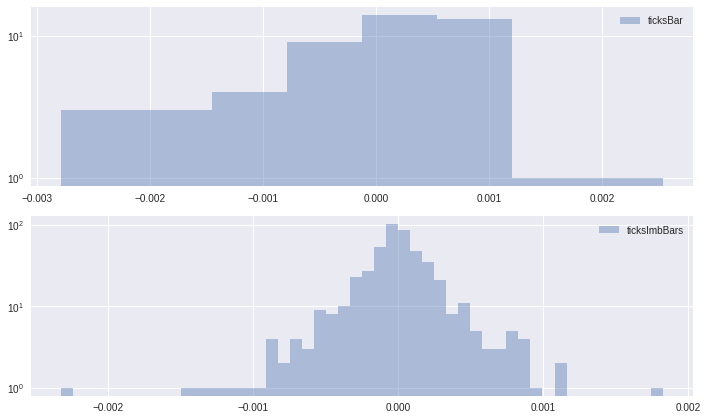

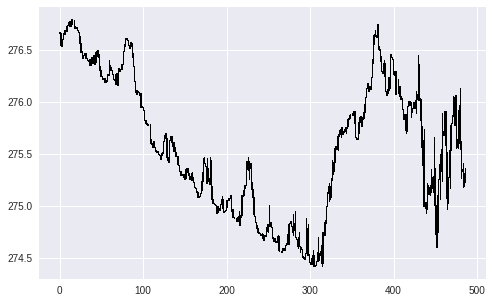

In [111]:
test_imb_bars = get_imbalance_bars(df1, 'price')    
ticksImbBars = df1.price.loc[test_imb_bars.stop].drop_duplicates()
ticksImbBars.head()

ticksBar = tick_df.price
ticksBar.head()

dr = returns(tick_df.price)
drImb = returns(ticksImbBars)

bar_types = ['ticksBar','ticksImbBars']
bar_rets = [dr, drImb]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(ticksImbBars).price)    
plotOHLC(tick_bars_ohlc)

**VOLUME IMBALANCE BARS**

,sample_size,jb_stat
vBar,642.0,1235.126774
vImbBars,481.0,1259.115289


,sample_size,shapiro_stat
vBar,642.0,0.922186
vImbBars,481.0,0.884426


100%|██████████| 481/481 [00:00<00:00, 3399.77it/s]


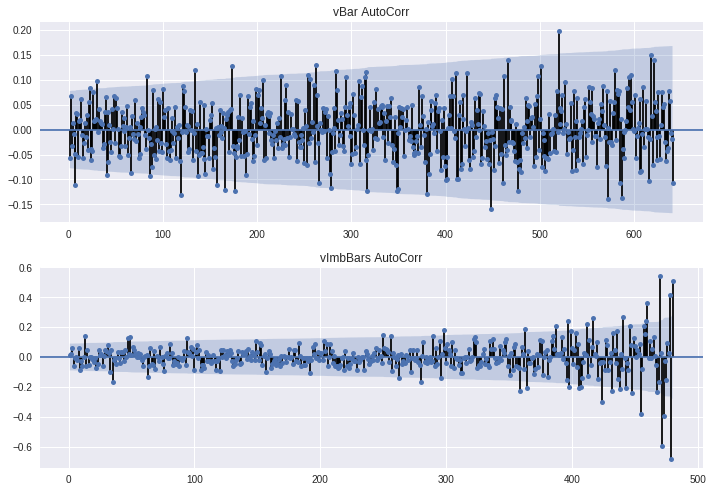

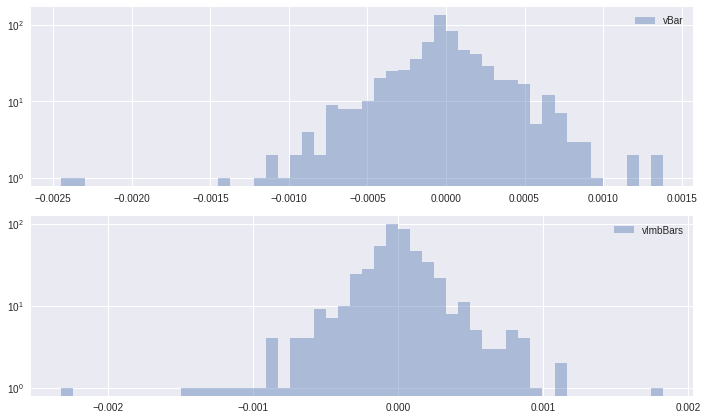

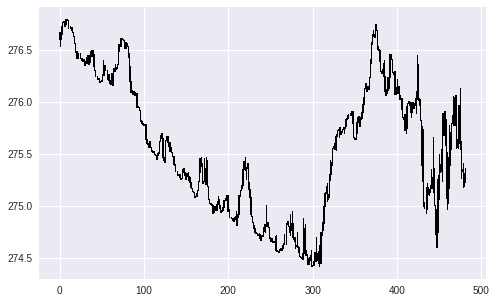

In [112]:
test_imb_bars = get_imbalance_bars(df1, 'v')    
vImbBars = df1.price.loc[test_imb_bars.stop].drop_duplicates()
vImbBars.head()

vBar = v_bar_df.price
vBar.head()

dr = returns(v_bar_df.price)
drImb = returns(vImbBars)

bar_types = ['vBar','vImbBars']
bar_rets = [dr, drImb]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(vImbBars).price)    
plotOHLC(tick_bars_ohlc)

**DOLLAR VOLUME IMBALANCE BARS**

,sample_size,jb_stat
dvBar,239.0,104.312655
dvImb,2347.0,22154.464232


,sample_size,shapiro_stat
dvBar,239.0,0.950777
dvImb,2347.0,0.867498


100%|██████████| 481/481 [00:00<00:00, 3389.77it/s]


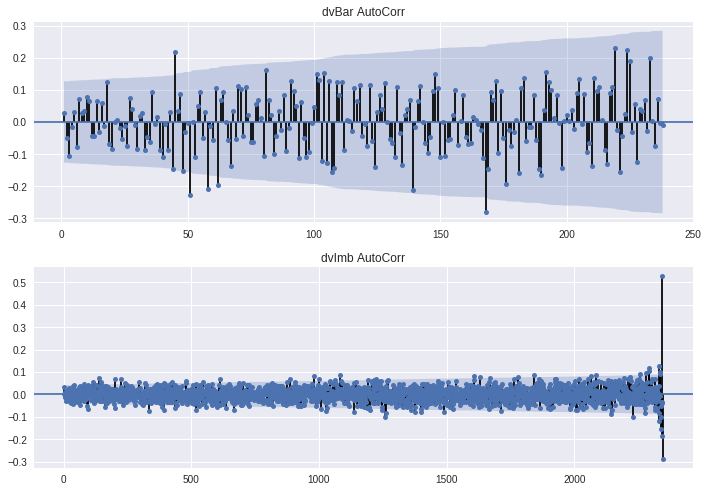

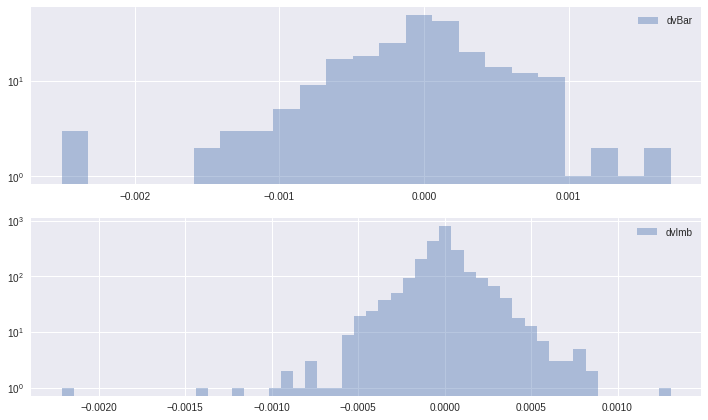

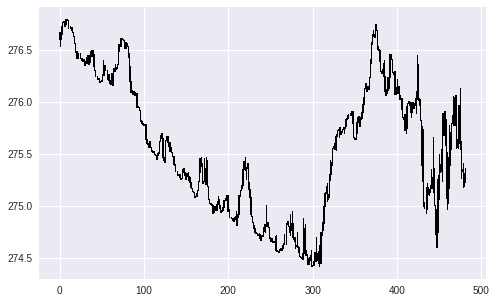

In [113]:
test_imb_bars = get_imbalance_bars(df1, 'dv')
dvImbBars = df1.price.loc[test_imb_bars.stop]
dvImbBars.head()

dvBar = dv_bar_df.price
dvBar.head()

dr = returns(dv_bar_df.price)
drImb = returns(dvImbBars)

bar_types = ['dvBar','dvImb']
bar_rets = [dr, drImb]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(vImbBars).price)    
plotOHLC(tick_bars_ohlc)

**TICK RUN BARS**

,sample_size,jb_stat
ticksRunBars,39.0,0.990833
ticksBar,48.0,1.742906


,sample_size,shapiro_stat
ticksRunBars,39.0,0.979247
ticksBar,48.0,0.965380


100%|██████████| 481/481 [00:00<00:00, 3305.47it/s]


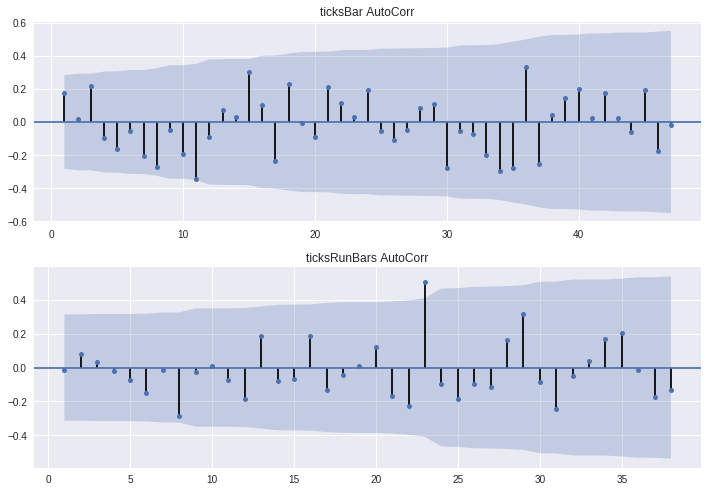

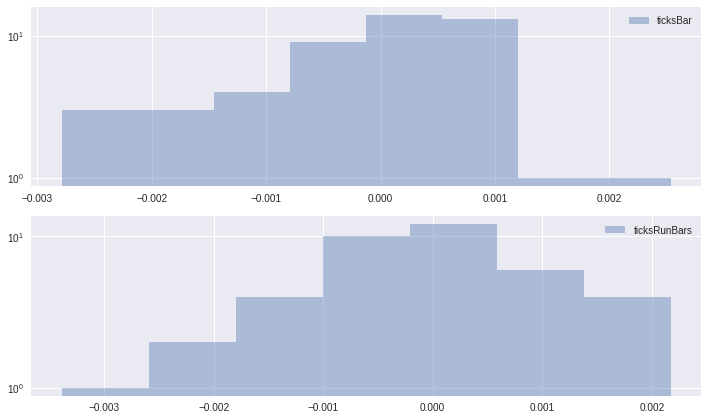

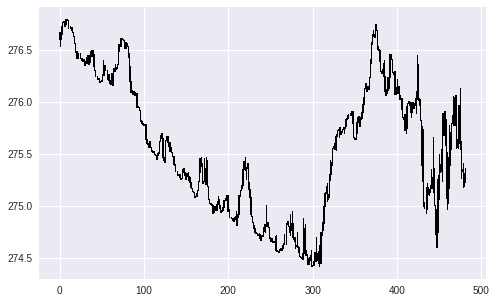

In [114]:
test_run_bars = get_run_bars(df1, 'price') 
ticksRunBars = df1.price.loc[test_run_bars.stop].drop_duplicates()
ticksRunBars.head()

ticksBar = tick_df.price
ticksBar.head()

dr = returns(tick_df.price)
drRun = returns(ticksRunBars)

bar_types = ['ticksBar','ticksRunBars']
bar_rets = [dr, drRun]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(vImbBars).price)    
plotOHLC(tick_bars_ohlc)

**VOLUME RUN BARS**

,sample_size,jb_stat
vRunBars,48.0,0.443413
vBar,642.0,1235.126774


,sample_size,shapiro_stat
vRunBars,48.0,0.990610
vBar,642.0,0.922186


100%|██████████| 481/481 [00:00<00:00, 3347.70it/s]


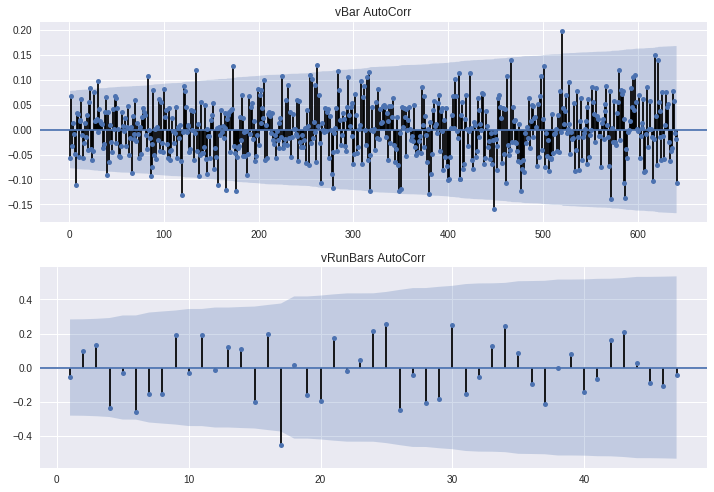

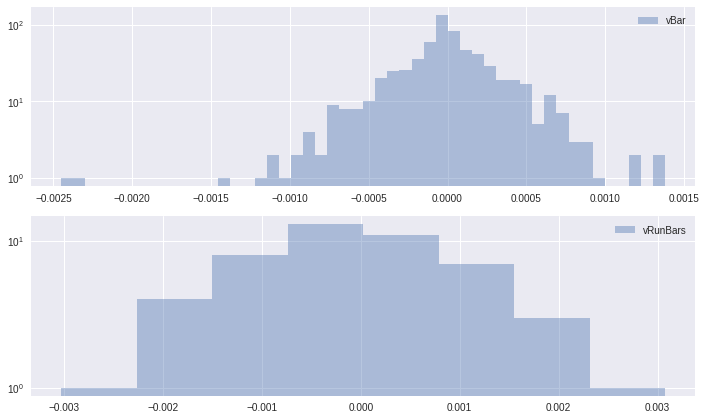

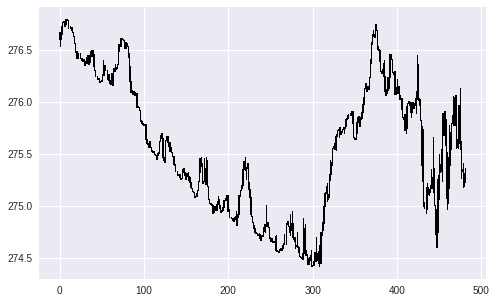

In [115]:
test_run_bars = get_run_bars(df1, 'v')    
vRunBars = df1.price.loc[test_run_bars.stop].drop_duplicates()
vRunBars.head()

vBar = v_bar_df.price
vBar.head()

dr = returns(v_bar_df.price)
drRun = returns(vRunBars)

bar_types = ['vBar','vRunBars']
bar_rets = [dr, drRun]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(vImbBars).price)    
plotOHLC(tick_bars_ohlc)

**DOLLAR VOLUME RUN  BARS**

,sample_size,jb_stat
dvRunBars,56.0,0.066602
dvBar,239.0,104.312655


,sample_size,shapiro_stat
dvRunBars,56.0,0.992117
dvBar,239.0,0.950777


100%|██████████| 481/481 [00:00<00:00, 3355.05it/s]


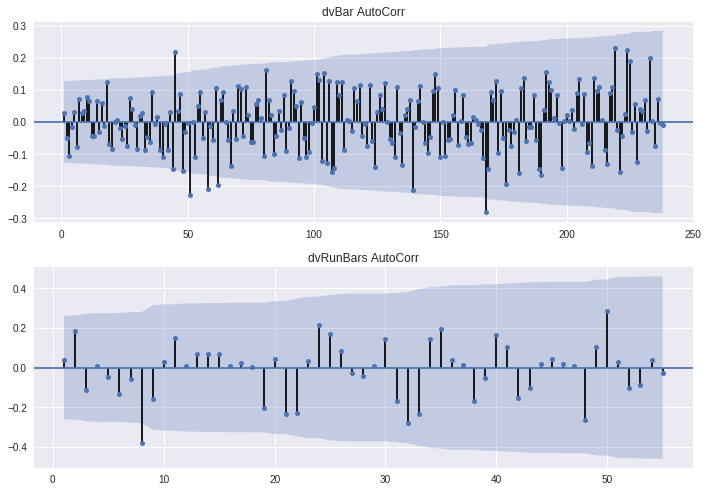

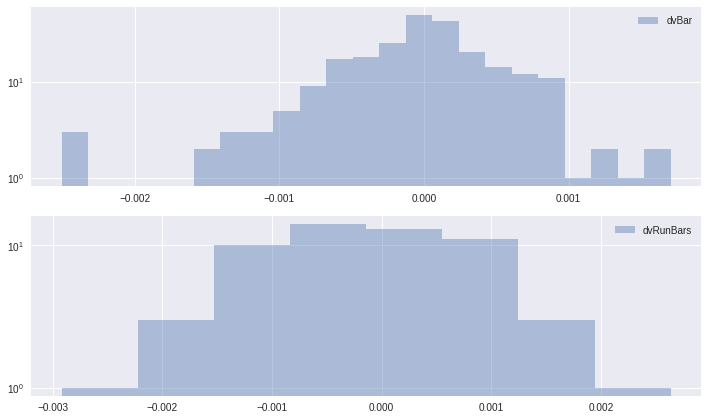

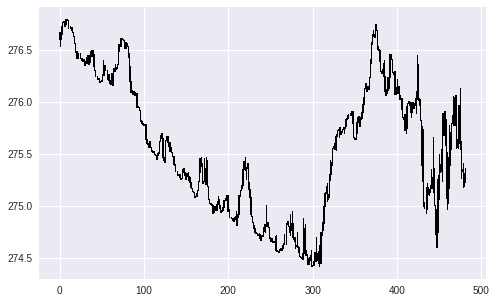

In [116]:
test_run_bars = get_run_bars(df1, 'dv')
dvRunBars = df1.price.loc[test_run_bars.stop]
dvRunBars.head()

dvBar = dv_bar_df.price
dvBar.head()

dr = returns(dv_bar_df.price)
drRun = returns(dvRunBars)

bar_types = ['dvBar','dvRunBars']
bar_rets = [dr, drRun]

analysisImbalanceBars(bar_types, bar_rets)

tick_bars_ohlc = get_ohlc(df1.price, pd.DataFrame(vImbBars).price)    
plotOHLC(tick_bars_ohlc)